# Transfer Learning With BERT

- In this tutorial, we show how to perform text classification of spammed mails using the pre-trained BERT model.
- This example also shows the effectiveness of **transfer learning**. 
- In particular, we will demonstrate:
    - BERT-based Transfer Learning
    - Customized BERT-based Transfer Learning by Fine-Tuning

## BERT in Short

- BERT is a model with absolute position embeddings so it’s usually advised to pad the inputs on the right rather than the left.

- The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. 
- It’s a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.
- In particular, BERT was trained with the masked language modeling (MLM) and next sentence prediction (NSP) objectives. It is efficient at predicting masked tokens and at NLU in general, but is not optimal for text generation.
- The size of the large BERT model:
    - Transformer blocks: 24
    - Embedding dimension: 1024
    - Attention heads: 16
    - Total number of parameters: 340M

- The size of GPT-2 Model:
    - Transformer blocks: 48
    - Sequence length: 1024
    - Embedding dimension: 1600
    - Total number of parameters: 1.5B

## Setup

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import sklearn
import unicodedata
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

# import tensorflow_hub as hub

# from sklearn.model_selection import train_test_split

# from tqdm import tqdm
# import pickle
# from keras.models import Model
# import keras.backend as K
# from sklearn.metrics import confusion_matrix,f1_score,classification_report
# import matplotlib.pyplot as plt
# from keras.callbacks import ModelCheckpoint
# import itertools
# from keras.models import load_model
# from sklearn.utils import shuffle
# from transformers import *
# from transformers import BertTokenizer, TFBertModel, BertConfig


## Data Loading

In [2]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [4]:
csv_file='../../../RepositoryData/data/kaggle-SMS-Spam-Collection-Dataset/spam.csv'
csv_data=pd.read_csv(csv_file,encoding='ISO-8859-1')
csv_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Data Preprocessing

![](../images/text-tokenization-embedding.png)

In [5]:
print('File has {} rows and {} columns'.format(csv_data.shape[0],csv_data.shape[1]))

File has 5572 rows and 5 columns


In [6]:
csv_data = csv_data.loc[:, ~csv_data.columns.str.contains('Unnamed: 2', case=False)] 
csv_data = csv_data.loc[:, ~csv_data.columns.str.contains('Unnamed: 3', case=False)] 
csv_data = csv_data.loc[:, ~csv_data.columns.str.contains('Unnamed: 4', case=False)] 


In [7]:
csv_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
csv_data=csv_data.dropna()                                                           # Drop NaN valuues, if any
csv_data=csv_data.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values
csv_data.rename(columns={'v1':'label','v2':'text'}, inplace=True)

In [9]:
csv_data = sklearn.utils.shuffle(csv_data)                                                         # Shuffle the dataset
#print('Available labels: ',data.label.unique())                              # Print all the unique labels in the dataset
csv_data['text']=csv_data['text'].map(preprocess_sentence)                           # Clean the text column using preprocess_sentence function defined above

In [10]:
print('File has {} rows and {} columns'.format(csv_data.shape[0],csv_data.shape[1]))
csv_data.head()

File has 5572 rows and 2 columns


,label,text
1160,ham,sure neighbors didnt pick
571,ham,know lab goggles went
2077,ham,hey hun onbus goin meet wants meal donyt feel ...
4319,ham,hey going sea view couple gays mean games give...
1360,ham,dude guess got arrested day


## BERT Tokenizer

[Google's open-sourced tensorflow implementation of BERT](https://github.com/google-research/bert):
- BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters
- BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters
- BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters
- BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters
- BERT-Base, Multilingual Case: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
- BERT-Base, Chinese: Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters

```{tip}
In `transformers`, there are several predefined tensorflow models that use BERT for classification. Please see Hugginface transformers's [BERT](https://huggingface.co/transformers/model_doc/bert.html) documentation.
```

In [17]:
num_classes = len(csv_data.label.unique())

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",
                                              add_special_tokens=True,
                                              do_lower_case=True,
                                              #max_length=150,
                                              pad_to_max_length=True,)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_113']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Intuition of BERT Tokenizer

In [173]:
sent= "Don't like it!"
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['don', "'", 't', 'like', 'it', '!']


Parameters of `TFBertForSequenceClassification` model:
- `input_ids`: The input ids are often the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model. This can be obtained by the BERT Tokenizer.
input_ids (Numpy array or tf.Tensor of shape (batch_size, sequence_length))
Indices of input sequence tokens in the vocabulary.
- `batch_size` : Number of examples or sentences batch
sequence_length : A number of tokens in a sentence.
2. attention_mask (Numpy array or tf.Tensor of shape (batch_size, sequence_length)) –
Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]: 1 for tokens that are not masked, 0 for tokens that are marked (0 if the token is added by padding).
This argument indicates to the model which tokens should be attended to, and which should not.
If we have 2 sentences and the sequence length of one sentence is 8 and another one is 10, then we need to make them of equal length and for that, padding is required. To distinguish between the padded and nonpadded input attention mask is used.
3. labels (tf.Tensor of shape (batch_size,), optional) – Labels for computing the sequence classification/regression loss.
Indices should be in [0, ..., num_classes- 1]. If num_classes == 1 a regression loss is computed (Mean-Square loss), If num_classes > 1 a classification loss is computed (Cross-Entropy).
These tokens can then be converted into IDs which are understandable by the model. This can be done by directly feeding the sentence to the tokenizer.

![](../images/bert-tokenizer.jpeg)

- tokens: This shows how BERT Tokenizer segments the text into smaller base units for further processing.
- `input_ids`: These correspond to the numeric index IDs of the tokens in the input (i.e., the **text_to_sequences()** in keras).
    - `[SEP]` and `[CLS]` are special tokens added by the tokenizer. 
    - `[SEP]` is needed when the task required two sequences at a time (e.g., in BERT training).
    - `[CLS]`, added at the beginning of the input, stand for classifier token. The embedding of this token can be seen as the **summary of the inputs**, which is ready for downstream classification problems. That is, this **pooled output** `[CLS]` is the input of the additional layers on top of the BERT model (i.e., `[CLS]` can be viewed as the document embeddings).
- `attention_mask`: Similar to keras Mask layer, this mask indicates with tokens are actual tokens and which are padding tokens so that the attention calculation would ignore the latter.

In [174]:
sent="Don't like it!"
tokenized_sequence= bert_tokenizer.encode_plus(
    sent,add_special_tokens = True, 
    max_length =10,
    padding = 'max_length',
    truncation=True,
    return_attention_mask = True)

In [170]:
tokenized_sequence

{'input_ids': [101, 2123, 1005, 1056, 2066, 2009, 999, 102, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}

In [175]:
bert_tokenizer.decode(
    tokenized_sequence['input_ids'],
    clean_up_tokenization_spaces=False,
)

"[CLS] don ' t like it ! [SEP] [PAD] [PAD]"

## From Text to BERT Input

In [43]:
csv_data['label_num'] = csv_data['label'].map({'ham':0,'spam':1})
csv_data.head()

,label,text,label_num
1160,ham,sure neighbors didnt pick,0
571,ham,know lab goggles went,0
2077,ham,hey hun onbus goin meet wants meal donyt feel ...,0
4319,ham,hey going sea view couple gays mean games give...,0
1360,ham,dude guess got arrested day,0


In [44]:
sentences=csv_data['text']
labels=csv_data['label_num']
len(sentences),len(labels)

(5572, 5572)

- When tokenizing, we can determine the `max_length` of each text. 
- Also, we need to specify `padding` and `truncation` to make sure that the tokenizer automatically pad/truncate the sequences to uniform lengths.

In [101]:
input_ids=[]
attention_masks=[]
segment_ids=[] # type-token ids


MAX_LEN = 50

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(
        sent,add_special_tokens = True, 
        max_length =MAX_LEN,
        #pad_to_max_length = True,
        padding= 'max_length',
        return_attention_mask = True, truncation=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])
    segment_ids.append(bert_inp['token_type_ids'])

## alvin's note:
## according to the warning, we should use `padding='max_length'` and specificay `max_length = 50`
## to make it work

In [61]:
input_ids[:1]

[[101,
  2469,
  10638,
  2134,
  2102,
  4060,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

In [111]:
input_ids=np.asarray(input_ids).astype('int32')
attention_masks=np.array(attention_masks)
segment_ids = np.array(segment_ids)
labels=np.array(labels)

In [112]:
len(input_ids),len(attention_masks),len(labels), len(segment_ids)


(5572, 5572, 5572, 5572)

- BERT Tokenizer returns a dictionary from which we can get the input ids and the attention masks.
- Convert all the encoding to NumPy arrays.
- Arguments of BERT Tokenizer:
    - text (str, List[str], List[List[str]]) – The sequence or batch of sequences to be encoded. Each sequence can be a string or a list of strings (pretokenized string). If the sequences are provided as list of strings (pretokenized), you must set is_split_into_words=True (to lift the ambiguity with a batch of sequences).
    - add_special_tokens (bool, optional, defaults to True) – Whether or not to encode the sequences with the special tokens relative to their model.
    - max_length (int, optional) — Controls the maximum length to use by one of the truncation/padding parameters. (max_length≤512)
    - padding (bool, optional, defaults to True) – Whether or not to pad the sequences to the maximum length.
    - return_attention_mask (bool, optional) –

## Train-Test Split

In [114]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask, train_seg, val_seg =sklearn.model_selection.train_test_split(input_ids,labels,attention_masks, segment_ids, test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (4457, 50) Val input shape (1115, 50)
Train label shape (4457,) Val label shape (1115,)
Train attention mask shape (4457, 50) Val attention mask shape (1115, 50)


## Model Setup

In [66]:
log_dir='./sentiment-analysis-using-bert-keras/tensorboard_data/tb_bert'
model_save_path='./sentiment-analysis-using-bert-keras/models/bert_model.h5'

import os
path = "./sentiment-analysis-using-bert-keras/models/"

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_113 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


:::{tip}

The BERT paper suggests a few heuristics for fine-tuning:

- Batch Size: 16 or 32
- Epochs: 2 to 4
- Learning Rates for Adam: 5e-5, 3e-5,, or 2e-5.

:::

## Model Training

- The BERT Classifier requires two inputs: the input ids and the attention mask.
- The output should be the one-hot encoded labels.

In [67]:
history=bert_model.fit([train_inp,train_mask],
                       train_label,
                       batch_size=32,
                       epochs=1,
                       validation_data=([val_inp,val_mask],val_label),
                       callbacks=callbacks)

  1/140 [..............................] - ETA: 0s - loss: 0.7168 - accuracy: 0.3438WARNING:tensorflow:From /Users/Alvin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
140/140 [==============================] - 1436s 10s/step - loss: 0.1496 - accuracy: 0.9502 - val_loss: 0.0503 - val_accuracy: 0.9883


In [69]:
bert_model.evaluate([val_inp,val_mask], val_label,batch_size=32)

35/35 [==============================] - 112s 3s/step - loss: 0.0503 - accuracy: 0.9883


[0.050305914133787155, 0.9883407950401306]

In [73]:
val_label_pred = bert_model.predict([val_inp,val_mask],batch_size=32)

In [82]:
val_label_pred_class = val_label_pred[0].argmax(axis=1)

In [85]:
print(val_label_pred_class[:10])
print(val_label[:10])

[0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 1]


In [96]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [94]:
cm = sklearn.metrics.confusion_matrix(val_label, val_label_pred_class, normalize=None)

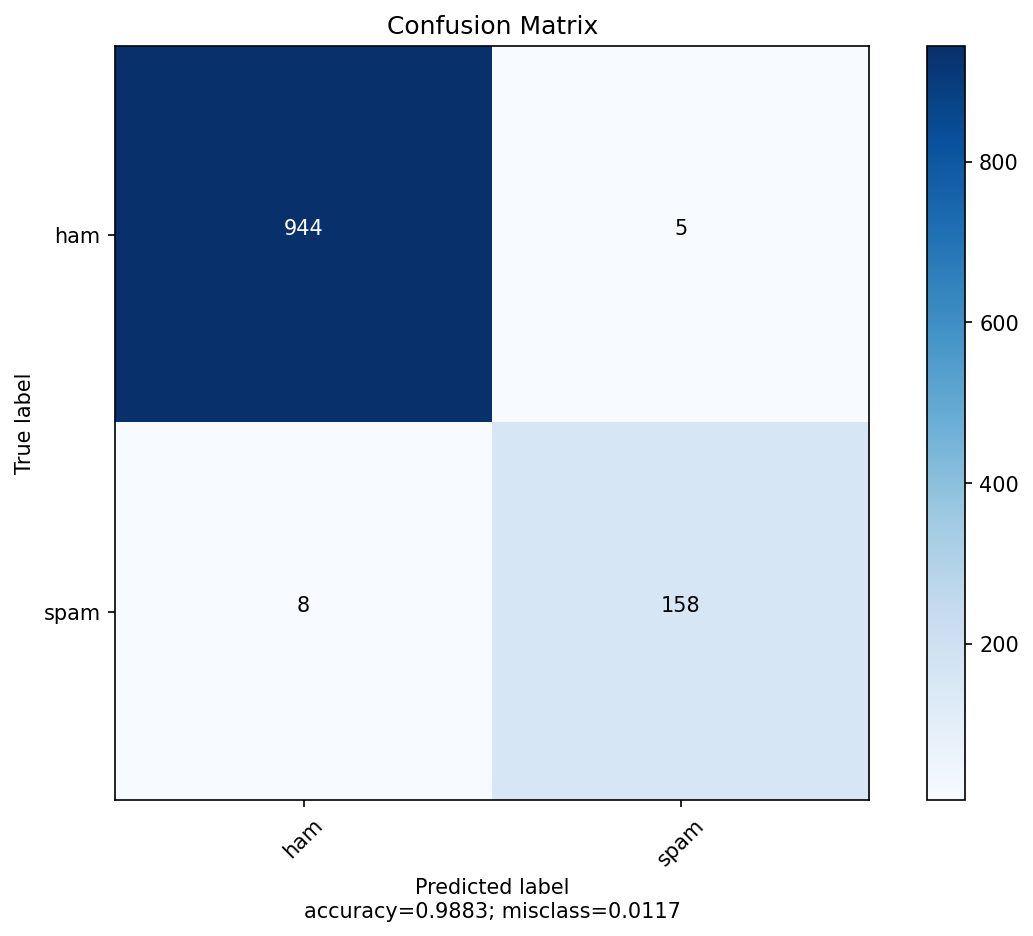

In [97]:
plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['ham', 'spam'],
                      title        = "Confusion Matrix")

In [71]:
# bert_model.save_weights(model_save_path)

## Model Evaluation Using Tensorbaord

In [144]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir {log_dir}

## Model Evaluation: Metrics

In [ ]:
# model_save_path='./sentiment-analysis-using-bert-keras/models/bert_model.h5'


trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)

In [158]:
pred_labels = preds[0].argmax(axis=1)
f1 = sklearn.metrics.f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')

target_names=csv_data.label.unique()
print(sklearn.metrics.classification_report(val_label,pred_labels,target_names=target_names))

print('Training and saving built model.....')

F1 score 0.9148936170212766
Classification Report
              precision    recall  f1-score   support

        spam       0.99      0.98      0.99       978
         ham       0.89      0.94      0.91       137

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Training and saving built model.....


In [159]:
trained_model.evaluate([val_inp,val_mask],batch_size=32)

35/35 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9785


[0.0, 0.9784753322601318]

## Custom Model with BERT

In [98]:
from transformers import TFBertModel

bert_custom = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [102]:
bert_custom.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [127]:
# MAX_LEN = 50

inp_ids = keras.layers.Input((MAX_LEN,), dtype=tf.int64, name="input_ids")
att_mask = keras.layers.Input((MAX_LEN,), dtype=tf.int64, name="attention_mask")
seg_ids = keras.layers.Input((MAX_LEN,), dtype=tf.int64, name="token_type_ids")


In [128]:
inp_dict = {"input_ids": inp_ids,
           "attention_mask": att_mask,
           "token_type_ids": seg_ids}
outputs = bert_custom(inp_dict) ## get the pooled output of each input sequence for fine-tuning

In [129]:
## The output of the each input token includes special token [SEP] and [CLS].
## The second one is [CLS], which is the pooled output of the entire input sequence
outputs

(<tf.Tensor 'tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm_1/add_1:0' shape=(None, 50, 768) dtype=float32>,
 <tf.Tensor 'tf_bert_model/bert/pooler/dense/Tanh_1:0' shape=(None, 768) dtype=float32>)

In [130]:
x = keras.layers.Dropout(0.2)(outputs[1])
x = keras.layers.Dense(200, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(2, activation="sigmoid")(x)
custom_model = keras.models.Model(inputs=inp_dict, outputs=x)
custom_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     multiple             109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]       

In [131]:
## Fine tune BERT on IMDB

input_dict = {"input_ids": train_inp,
           "attention_mask": train_mask,
           "token_type_ids": train_seg}
val_dict = {"input_ids": val_inp,
           "attention_mask": val_mask,
           "token_type_ids": val_seg}

In [132]:
custom_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

### Principles for Fine-Tuning BERT

- Fine-tuning should be run for a small number of epochs with a small value for Adam's learning rate.
- Too many epochs may run the task of BERT forgetting its pretrained parameters.
- But a few epochs may not be enough for the training of the layers on top of the BERT.
- We can freeze the BERT layer.

In [136]:
## Freeze BERT layer

##print(bert_custom.trainable)

bert_custom.trainable=False
optimizer = tf.keras.optimizers.Adam() ## standard learning rate
custom_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

custom_model.summary() ## check the number of trainable parameters

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     multiple             109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]       

In [137]:
custom_history = custom_model.fit(input_dict, train_label, batch_size=32,
                       epochs=3,
                       validation_data=(val_dict,val_label))

Epoch 1/3
140/140 [==============================] - 529s 4s/step - loss: 0.4405 - accuracy: 0.8943 - val_loss: 0.4747 - val_accuracy: 0.8386
Epoch 2/3
140/140 [==============================] - 526s 4s/step - loss: 0.4405 - accuracy: 0.8728 - val_loss: 0.4747 - val_accuracy: 0.8386
Epoch 3/3
140/140 [==============================] - 543s 4s/step - loss: 0.4405 - accuracy: 0.8728 - val_loss: 0.4747 - val_accuracy: 0.8386


## References

- [BERT Text Classification Using Keras](https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d)
- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Extraction with BERT](https://keras.io/examples/nlp/text_extraction_with_bert/#text-extraction-with-bert)